In [1]:
import numpy as np
import random
import os
import datetime
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv3D, Flatten, TimeDistributed, 
                                       BatchNormalization, Activation, LSTM, 
                                       MaxPooling3D, MaxPooling2D, Input, Dropout)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

# Set seeds for reproducibility
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)


2025-03-31 09:41:30.053216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743394290.064708   19008 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743394290.068422   19008 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743394290.078418   19008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743394290.078427   19008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743394290.078428   19008 computation_placer.cc:177] computation placer alr

In [2]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 4 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [3]:
def generator(source_path, folder_list, batch_size, num_frames):
    """
    Yields batches of video data and one-hot labels.
    
    Each folder entry is assumed to be formatted as "folder_name;other_info;label_index".
    """
    # Constants for video processing
    img_height = 112   # target height
    img_width = 112    # target width
    num_classes = 5    # number of classes
    
    # List of frame indices to use for each video folder
    img_idx = list(range(num_frames))
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        # Process full batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, num_classes), dtype=np.float32)
            
            for i in range(batch_size):
                # "folder_name;other_info;label_index"
                folder_info = t[i + batch * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = cv2.imread(image_path)
                    if image is None:
                        continue  # Skip if the image is not read properly
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels
        
        # Process remaining samples (if any)
        remainder = len(t) % batch_size
        if remainder > 0:
            batch_data = np.zeros((remainder, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((remainder, num_classes), dtype=np.float32)
            
            for i in range(remainder):
                folder_info = t[i + num_batches * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = cv2.imread(image_path)
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels

In [4]:


# Get the current date and time
curr_dt_time = datetime.datetime.now()
print("Current date and time:", curr_dt_time)

# Define paths for training and validation datasets
train_path = './Project_data/train'
val_path = './Project_data/val'

# Assuming train_doc and val_doc are lists containing the training and validation data
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Choose the number of epochs, here we set it to 10 (modify as needed)
num_epochs = 10
print('# epochs =', num_epochs)


Current date and time: 2025-03-31 09:41:31.400812
# training sequences = 663
# validation sequences = 100
# epochs = 10


In [5]:



def plothistorygraph(history):
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


### Experiment 1

##### (CNN + LSTM)

In [6]:
# -------------------------
# Model Definition (CNN + LSTM)
# -------------------------
num_frames = 16
img_height = 112
img_width = 112
num_classes = 5

# Input: a sequence of frames
inputs = Input(shape=(num_frames, img_height, img_width, 3))
# TimeDistributed CNN: apply Conv2D on each frame
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Flatten())(x)
# LSTM to capture temporal dynamics
x = LSTM(128, return_sequences=False)(x)
# Dense layers for classification
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()


I0000 00:00:1743394291.811590   19008 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743394291.812757   19008 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5439 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,810,245 (98.46 MB)

 Trainable params: 25,810,053 (98.46 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,810,245 (98.46 MB)

 Trainable params: 25,810,053 (98.46 MB)

 Non-trainable params: 192 (768.00 B)

None


In [8]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# -------------------------
# Training Setup
# -------------------------
batch_size = 2  # Reduce batch size to help mitigate memory issues

# Create tf.data.Dataset from the generator
def get_dataset(source_path, doc, batch_size, num_frames):
    return tf.data.Dataset.from_generator(
        lambda: generator(source_path, doc, batch_size, num_frames),
        output_signature=(
            tf.TensorSpec(shape=(None, num_frames, img_height, img_width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    )

train_dataset = get_dataset(train_path, train_doc, batch_size, num_frames)
val_dataset = get_dataset(val_path, val_doc, batch_size, num_frames)

# Repeat and prefetch datasets
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [9]:
steps_per_epoch = (num_train_sequences // batch_size) + (1 if num_train_sequences % batch_size else 0)
validation_steps = (num_val_sequences // batch_size) + (1 if num_val_sequences % batch_size else 0)

# Callback: Early stopping based on validation loss
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

In [10]:

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    initial_epoch=0
)

Epoch 1/10


I0000 00:00:1743394297.003723   19215 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - categorical_accuracy: 0.2474 - loss: 1.6442 - val_categorical_accuracy: 0.5200 - val_loss: 1.3323
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.4547 - loss: 1.3168 - val_categorical_accuracy: 0.5500 - val_loss: 1.2306
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.5884 - loss: 1.1383 - val_categorical_accuracy: 0.5400 - val_loss: 1.1472
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.6818 - loss: 0.9190 - val_categorical_accuracy: 0.6200 - val_loss: 1.0324
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - categorical_accuracy: 0.7476 - loss: 0.7737 - val_categorical_accuracy: 0.6200 - val_loss: 0.9866
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.8390 - loss: 0.5470 - val_categorical_accuracy: 0.6000 - val_loss: 1.0807
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.9111 - 

Training Accuracy: 0.97%   

Validation Accuracy: 0.64%

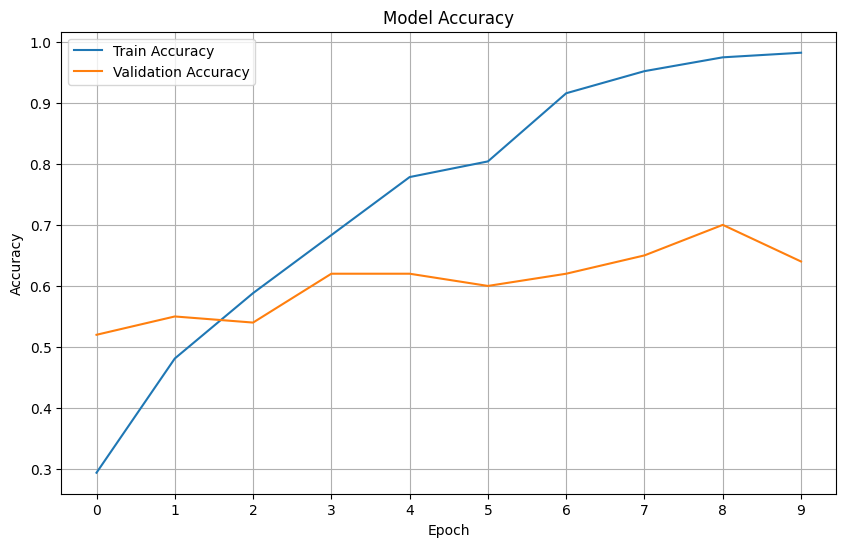

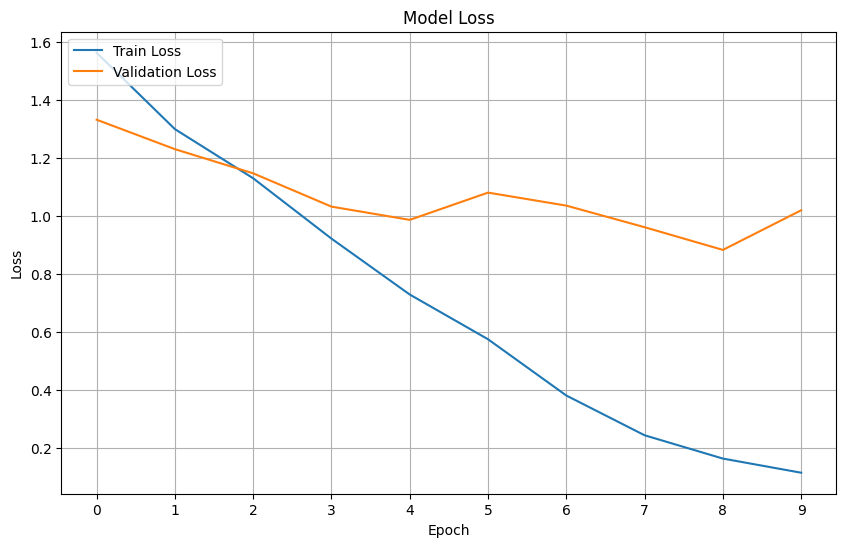

In [11]:
plothistorygraph(history=history)

### Experiment 2

(CNN + Batch Normalisation) 

In [12]:
# Define input dimensions for your video data
num_frames = 15   # Number of frames per video
img_height = 112  # Height of each frame
img_width = 112   # Width of each frame

# Define the input shape (3 channels for RGB)
input_shape = (num_frames, img_height, img_width, 3)

model = Sequential()
# Use an explicit Input layer
model.add(Input(shape=input_shape))

# 1st convolutional block
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd convolutional block
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd convolutional block
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Final classification layer - assumes 5 classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,971,845 (99.07 MB)

 Trainable params: 25,971,397 (99.07 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,971,845 (99.07 MB)

 Trainable params: 25,971,397 (99.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [14]:
# Define your generators
train_generator = generator(train_path, train_doc, batch_size, num_frames=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_frames=num_frames)

In [15]:
# Define model name and create directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the filepath for saving the model
filepath = model_name + "model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}.h5"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Define the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Epoch 1/10


I0000 00:00:1743394459.623575   19192 service.cc:152] XLA service 0x77a39c006110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743394459.623602   19192 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-31 09:44:19.657524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  5/332 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - categorical_accuracy: 0.2767 - loss: 3.5319    

I0000 00:00:1743394462.948841   19192 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.3438 - loss: 6.2728
Epoch 1: saving model to model_init_2025-03-3109_41_31.400812/model-01-4.17-0.41.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - categorical_accuracy: 0.3440 - loss: 6.2665 - val_categorical_accuracy: 0.2700 - val_loss: 3.4819 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.6643 - loss: 1.2499
Epoch 2: saving model to model_init_2025-03-3109_41_31.400812/model-02-1.19-0.64.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - categorical_accuracy: 0.6642 - loss: 1.2495 - val_categorical_accuracy: 0.5600 - val_loss: 1.7295 - learning_rate: 1.0000e-04
Epoch 3/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.6741 - loss: 1.0007
Epoch 3: saving model to model_init_2025-03-3109_41_31.400812/model-03-0.96-0.72.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - categorical_accuracy: 0.6745 - loss: 1.0003 - val_categorical_accuracy: 0.5700 - val_loss: 2.1839 - learning_rate: 1.0000e-04
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.7760 - loss: 0.9145
Epoch 4: saving model to model_init_2025-03-3109_41_31.400812/model-04-0.81-0.78.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - categorical_accuracy: 0.7760 - loss: 0.9142 - val_categorical_accuracy: 0.7100 - val_loss: 1.4373 - learning_rate: 1.0000e-04
Epoch 5/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.8288 - loss: 0.5550
Epoch 5: saving model to model_init_2025-03-3109_41_31.400812/model-05-0.74-0.80.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - categorical_accuracy: 0.8285 - loss: 0.5567 - val_categorical_accuracy: 0.5600 - val_loss: 2.8318 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.7947 - loss: 0.8056
Epoch 6: saving model to model_init_2025-03-3109_41_31.400812/model-06-0.66-0.82.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - categorical_accuracy: 0.7948 - loss: 0.8047 - val_categorical_accuracy: 0.5600 - val_loss: 3.9277 - learning_rate: 1.0000e-04
Epoch 7/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8339 - loss: 0.7120
Epoch 7: saving model to model_init_2025-03-3109_41_31.400812/model-07-0.66-0.83.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.8339 - loss: 0.7116 - val_categorical_accuracy: 0.6500 - val_loss: 2.7957 - learning_rate: 1.0000e-04
Epoch 8/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8818 - loss: 0.4878
Epoch 8: saving model to model_init_2025-03-3109_41_31.400812/model-08-0.56-0.87.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.8818 - loss: 0.4882 - val_categorical_accuracy: 0.6400 - val_loss: 3.1472 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9134 - loss: 0.2770
Epoch 9: saving model to model_init_2025-03-3109_41_31.400812/model-09-0.29-0.92.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.9134 - loss: 0.2770 - val_categorical_accuracy: 0.6500 - val_loss: 1.6341 - learning_rate: 1.0000e-04
Epoch 10/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9337 - loss: 0.3008
Epoch 10: saving model to model_init_2025-03-3109_41_31.400812/model-10-0.36-0.92.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.9336 - loss: 0.3010 - val_categorical_accuracy: 0.7100 - val_loss: 2.6138 - learning_rate: 1.0000e-04


Training Accuracy: 0.93%

Validation Accuracy: 0.71%

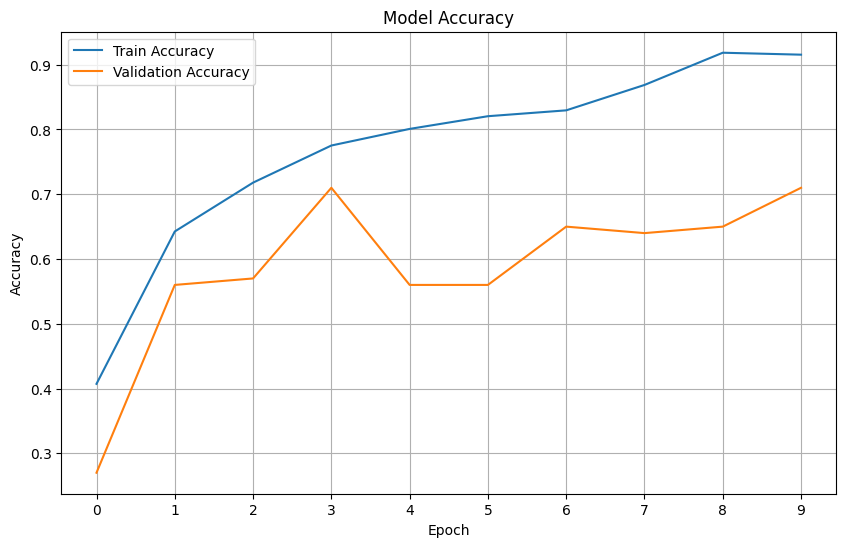

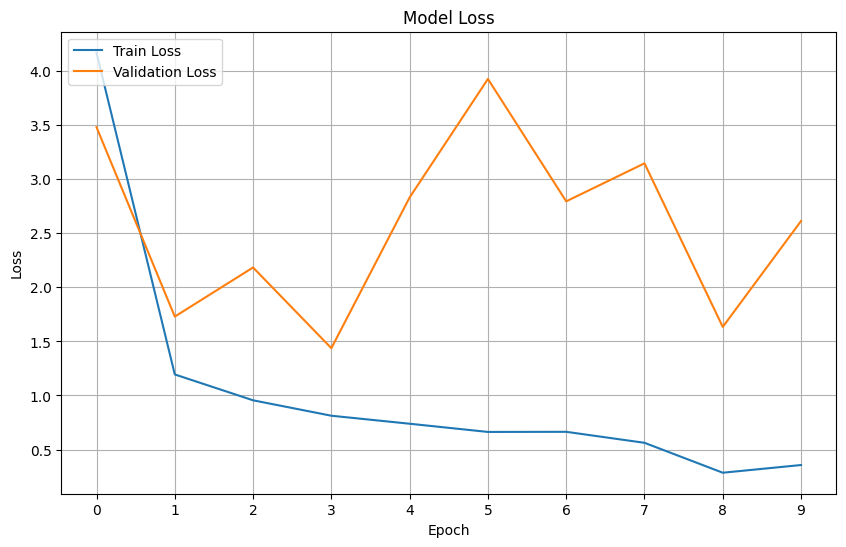

In [18]:
plothistorygraph(history=history)

#### Experiment 3

(CNN + Batch Normalisation) - increased number of frames and epochs

In [19]:
# Define input dimensions for your video data
num_frames = 25   # Number of frames per video
img_height = 112  # Height of each frame
img_width = 112   # Width of each frame

# Define the input shape (3 channels for RGB)
input_shape = (num_frames, img_height, img_width, 3)

model = Sequential()
# Use an explicit Input layer
model.add(Input(shape=input_shape))

# 1st convolutional block
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd convolutional block
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd convolutional block
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Final classification layer - assumes 5 classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 25, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 25, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 25, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 13, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,239,429 (172.57 MB)

 Trainable params: 45,238,981 (172.57 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 25, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 25, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 25, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 13, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,239,429 (172.57 MB)

 Trainable params: 45,238,981 (172.57 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [21]:
# Define your generators
train_generator = generator(train_path, train_doc, batch_size, num_frames=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_frames=num_frames)

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
# Fit the model
num_epochs = 20 # increased the epochs
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.3445 - loss: 8.9303
Epoch 1: saving model to model_init_2025-03-3109_41_31.400812/model-01-5.85-0.41.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - categorical_accuracy: 0.3447 - loss: 8.9211 - val_categorical_accuracy: 0.2100 - val_loss: 4.0458 - learning_rate: 1.0000e-04
Epoch 2/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.6494 - loss: 1.1989
Epoch 2: saving model to model_init_2025-03-3109_41_31.400812/model-02-1.39-0.64.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - categorical_accuracy: 0.6493 - loss: 1.2006 - val_categorical_accuracy: 0.6600 - val_loss: 1.2673 - learning_rate: 1.0000e-04
Epoch 3/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7320 - loss: 0.9557
Epoch 3: saving model to model_init_2025-03-3109_41_31.400812/model-03-0.93-0.73.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - categorical_accuracy: 0.7320 - loss: 0.9556 - val_categorical_accuracy: 0.6300 - val_loss: 1.3513 - learning_rate: 1.0000e-04
Epoch 4/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8333 - loss: 0.5965
Epoch 4: saving model to model_init_2025-03-3109_41_31.400812/model-04-0.78-0.80.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - categorical_accuracy: 0.8331 - loss: 0.5976 - val_categorical_accuracy: 0.7200 - val_loss: 2.0195 - learning_rate: 1.0000e-04
Epoch 5/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8066 - loss: 0.6900
Epoch 5: saving model to model_init_2025-03-3109_41_31.400812/model-05-0.69-0.79.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - categorical_accuracy: 0.8065 - loss: 0.6900 - val_categorical_accuracy: 0.7500 - val_loss: 1.7877 - learning_rate: 1.0000e-04
Epoch 6/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8481 - loss: 0.5336
Epoch 6: saving model to model_init_2025-03-3109_41_31.400812/model-06-0.75-0.83.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - categorical_accuracy: 0.8480 - loss: 0.5350 - val_categorical_accuracy: 0.6700 - val_loss: 3.0166 - learning_rate: 1.0000e-04
Epoch 7/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.8502 - loss: 0.7203
Epoch 7: saving model to model_init_2025-03-3109_41_31.400812/model-07-0.68-0.84.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - categorical_accuracy: 0.8501 - loss: 0.7201 - val_categorical_accuracy: 0.7600 - val_loss: 1.4261 - learning_rate: 1.0000e-04
Epoch 8/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.8399 - loss: 0.7658
Epoch 8: saving model to model_init_2025-03-3109_41_31.400812/model-08-0.68-0.85.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.8400 - loss: 0.7650 - val_categorical_accuracy: 0.6100 - val_loss: 2.9941 - learning_rate: 1.0000e-04
Epoch 9/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.8872 - loss: 0.5398
Epoch 9: saving model to model_init_2025-03-3109_41_31.400812/model-09-0.52-0.88.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.8871 - loss: 0.5397 - val_categorical_accuracy: 0.7900 - val_loss: 2.9366 - learning_rate: 1.0000e-04
Epoch 10/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.8223 - loss: 1.0642
Epoch 10: saving model to model_init_2025-03-3109_41_31.400812/model-10-0.77-0.84.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.8225 - loss: 1.0616 - val_categorical_accuracy: 0.7600 - val_loss: 1.8711 - learning_rate: 1.0000e-04
Epoch 11/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.8953 - loss: 0.6130
Epoch 11: saving model to model_init_2025-03-3109_41_31.400812/model-11-0.71-0.88.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.8953 - loss: 0.6132 - val_categorical_accuracy: 0.7500 - val_loss: 1.6536 - learning_rate: 1.0000e-04
Epoch 12/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.8722 - loss: 0.6662
Epoch 12: saving model to model_init_2025-03-3109_41_31.400812/model-12-0.64-0.87.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.8723 - loss: 0.6660 - val_categorical_accuracy: 0.8100 - val_loss: 2.1817 - learning_rate: 1.0000e-04
Epoch 13/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9063 - loss: 0.2785
Epoch 13: saving model to model_init_2025-03-3109_41_31.400812/model-13-0.31-0.92.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9063 - loss: 0.2787 - val_categorical_accuracy: 0.8400 - val_loss: 1.1476 - learning_rate: 1.0000e-05
Epoch 14/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9262 - loss: 0.2222
Epoch 14: saving model to model_init_2025-03-3109_41_31.400812/model-14-0.23-0.93.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9262 - loss: 0.2222 - val_categorical_accuracy: 0.8200 - val_loss: 1.1405 - learning_rate: 1.0000e-05
Epoch 15/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9616 - loss: 0.1329
Epoch 15: saving model to model_init_2025-03-3109_41_31.400812/model-15-0.14-0.95.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9615 - loss: 0.1330 - val_categorical_accuracy: 0.8300 - val_loss: 1.0786 - learning_rate: 1.0000e-05
Epoch 16/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9550 - loss: 0.1380
Epoch 16: saving model to model_init_2025-03-3109_41_31.400812/model-16-0.13-0.95.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9550 - loss: 0.1379 - val_categorical_accuracy: 0.8300 - val_loss: 1.1340 - learning_rate: 1.0000e-05
Epoch 17/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9615 - loss: 0.1094
Epoch 17: saving model to model_init_2025-03-3109_41_31.400812/model-17-0.13-0.95.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - categorical_accuracy: 0.9614 - loss: 0.1095 - val_categorical_accuracy: 0.8400 - val_loss: 0.9572 - learning_rate: 1.0000e-05
Epoch 18/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9687 - loss: 0.0958
Epoch 18: saving model to model_init_2025-03-3109_41_31.400812/model-18-0.10-0.97.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9687 - loss: 0.0959 - val_categorical_accuracy: 0.8100 - val_loss: 1.1585 - learning_rate: 1.0000e-05
Epoch 19/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9594 - loss: 0.1181
Epoch 19: saving model to model_init_2025-03-3109_41_31.400812/model-19-0.13-0.97.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9594 - loss: 0.1181 - val_categorical_accuracy: 0.8000 - val_loss: 1.0565 - learning_rate: 1.0000e-05
Epoch 20/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9821 - loss: 0.0540
Epoch 20: saving model to model_init_2025-03-3109_41_31.400812/model-20-0.08-0.98.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9821 - loss: 0.0543 - val_categorical_accuracy: 0.8200 - val_loss: 1.0339 - learning_rate: 1.0000e-05


Training Accuracy: 0.98%

Validation Accuracy: 0.82%

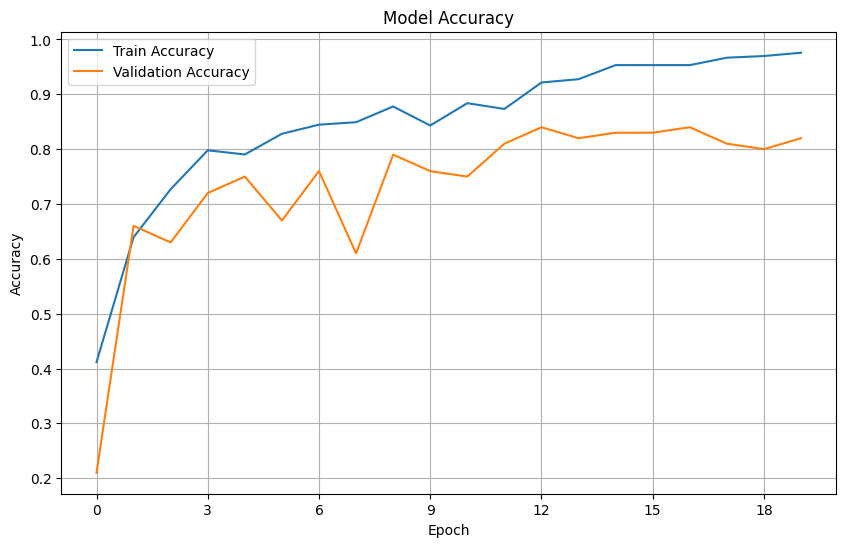

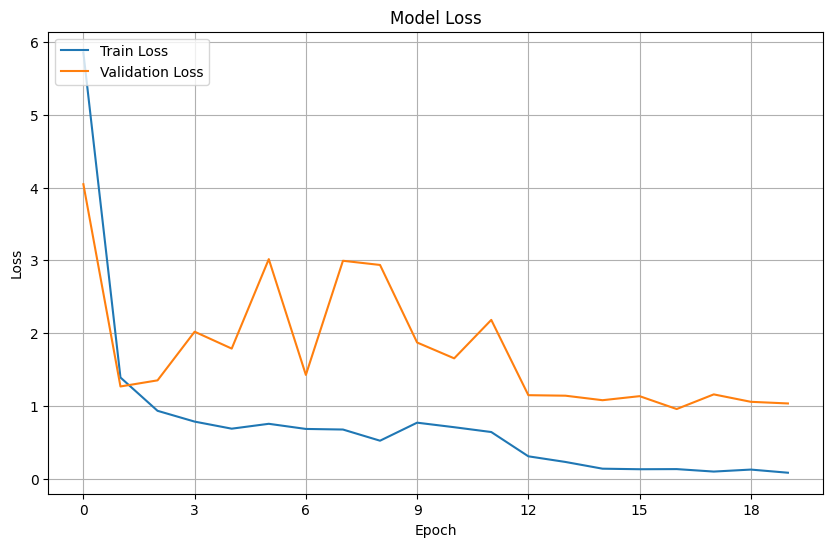

In [24]:
plothistorygraph(history=history)

Experiment 3 (Gesture Recognition): Integrated a CNN with Batch Normalization, increased the number of frames per video sample, and extended training epochs.
These enhancements improved feature extraction and generalization, leading to higher training and validation accuracy in gesture recognition.